/tmp/ipython-input-1395253944.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER_SYMBOL, start='2015-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 0.0817 - val_loss: 0.0030
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 0.0023 - val_loss: 0.0019
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
--- BACKTEST RESULTS ---
Total Trades: 279
Win Rate: 50.18%
Profit Factor: 1.41
Total PnL: 1.03
Ma

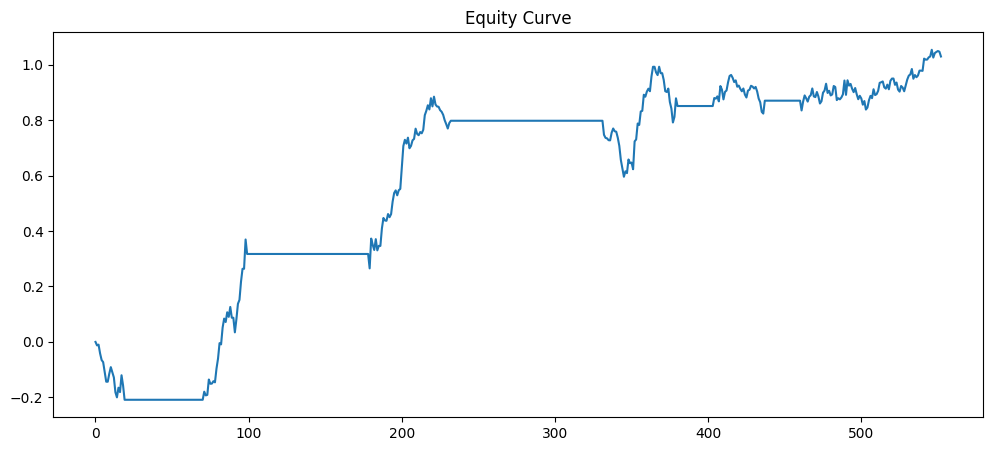

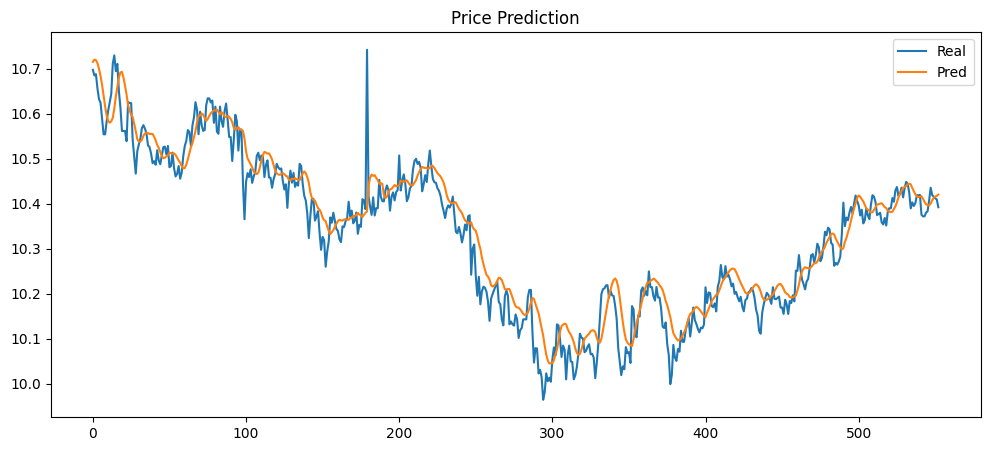

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ---------------------------
# 1. DATA LOADING
# ---------------------------
TICKER_SYMBOL = 'EURMAD=X'

data = yf.download(TICKER_SYMBOL, start='2015-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
df = data[['Close']].dropna()

# ---------------------------
# 2. FEATURE ENGINEERING
# ---------------------------
df['Return'] = df['Close'].pct_change()
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))
df['Vol'] = df['LogRet'].rolling(20).std()
df['Momentum'] = df['Close'].pct_change(10)
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df.dropna(inplace=True)

features = ['Close', 'Return', 'Vol', 'Momentum', 'MA20', 'MA50']

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

TIME_STEP = 60

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step, 0])  # predict close
    return np.array(X), np.array(y)

X, y = create_dataset(scaled, TIME_STEP)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ---------------------------
# 3. MODEL
# ---------------------------
model = Sequential([
    LSTM(80, return_sequences=True, input_shape=(TIME_STEP, len(features))),
    LSTM(80),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# ---------------------------
# 4. PREDICTIONS
# ---------------------------
pred = model.predict(X_test)
pred_close = scaler.inverse_transform(
    np.concatenate([pred, np.zeros((len(pred), len(features)-1))], axis=1)
)[:,0]

real_close = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), len(features)-1))], axis=1)
)[:,0]

# ---------------------------
# 5. SIGNALS (with trend filter)
# ---------------------------
trend = df['MA20'].values[-len(real_close):] > df['MA50'].values[-len(real_close):]
signals = np.where(pred_close > real_close, 1, -1)

# Trend filter: trade only in trend direction
signals = np.where(trend, signals, 0)

# ---------------------------
# 6. BACKTEST (stop-loss + take-profit)
# ---------------------------
trades = []
equity = [0.0]

SL = 0.005  # 0.5%
TP = 0.01   # 1%

for i in range(len(signals)-1):
    if signals[i] == 0:
        equity.append(equity[-1])
        continue

    entry = real_close[i]
    exit_ = real_close[i+1]
    pnl = signals[i] * (exit_ - entry)

    # Stop loss / take profit
    if pnl < -SL*entry:
        pnl = -SL*entry
    elif pnl > TP*entry:
        pnl = TP*entry

    trades.append(pnl)
    equity.append(equity[-1] + pnl)

trades = np.array(trades)
equity = np.array(equity)

# ---------------------------
# 7. METRICS
# ---------------------------
total_trades = len(trades)
wins = trades[trades > 0]
losses = trades[trades < 0]

win_rate = len(wins) / total_trades * 100 if total_trades else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.inf
total_pnl = trades.sum()

peak = np.maximum.accumulate(equity)
drawdown = equity - peak
max_drawdown = drawdown.min()

print("--- BACKTEST RESULTS ---")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Total PnL: {total_pnl:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")

# ---------------------------
# 8. PLOTS
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(equity)
plt.title("Equity Curve")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(real_close, label='Real')
plt.plot(pred_close, label='Pred')
plt.legend()
plt.title("Price Prediction")
plt.show()
